In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-08-12 22:26:05.527127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 22:26:05.696083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 22:26:05.736976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 22:26:05.989210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 22:26:07.619335: W tensorflow/compiler/tf2

Num GPUs Available:  1


I0000 00:00:1723512369.609163  511782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723512369.859531  511782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723512369.859593  511782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Todas las mediciones se realizaron con:
-   trigger: 880 adus
-   V_prog: 1480 mV
-   HV: 1230V
-   sc1: 1
-   t: 5 min

Intentemos primeramente cargar los datos y ver qué forma tienen los pulsos

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import re
import os
import csv

Algunas funciones para reutilizar código

In [3]:
def sub_arr(arr):
    """
    Retorna una sub-array de 'arr' que contiene todos los elementos no negativos (pulso) 
    que se extienden hacia afuera desde el índice 8 hasta que se encuentran elementos negativos en ambos extremos.
    
    Parámetros:
    arr (list): Una lista de números enteros (evento).
    
    Retorna:
    list: Una sub-array de 'arr' con números enteros no negativos (pulso).
    """
    start, end = 8, 8
    while start >= 0 and arr[start] > 0:
        start -= 1
    while end < len(arr) and arr[end] > 0:
        end += 1
    if start == -1 and end == len(arr):
        return []
    if arr[start] < 0:
        start += 1
    if arr[end - 1] < 0:
        end -= 1
    return arr[start:end]

In [4]:
def subsegments(new_data):
    """
    Genera subsegmentos de datos a partir de segmentos proporcionados.

    Parámetros:
    new_data (list): Una lista de listas de números enteros (segmentos de datos).

    Retorna:
    list: Una lista de subsegmentos de datos.
    """
    return [sub_arr(segment) for segment in new_data if len(sub_arr(segment)) > 0]

In [5]:
def load_data(file_list):
    """
    Carga datos de una lista de archivos, calcula los máximos, las sumas y los pulsos promedio.

    Parámetros:
    file_list (list): Una lista de rutas de archivos a cargar.

    Retorna:
    tuple: Tres listas, una con los máximos, otra con las sumas y otra con los pulsos promedio para cada archivo.
    """
    all_max_per_file, all_sum_per_file = [], []
    for file in file_list:
        data = np.loadtxt(file, np.int32, usecols=0)
        print(f'Longitud de {file}: {len(data)}')
        num_segments = len(data) // 32
        new_data = data[:num_segments * 32].reshape(-1, 32)
        subsegment_data = subsegments(new_data)
        if subsegment_data:
            max_values = [np.max(subsegment) for subsegment in subsegment_data]
            all_max_per_file.append(max_values)
            sum_values = [np.sum(subsegment) for subsegment in subsegment_data]
            all_sum_per_file.append(sum_values)
    return all_max_per_file, all_sum_per_file

In [6]:
def plot_histogram(data, bin_width, labels, title, x_label, y_label, log_scale=False, xlim=None):
    """
    Genera y muestra un histograma a partir de los datos proporcionados.

    Parámetros:
    data (list): Lista de listas con los datos a graficar.
    bin_width (int): Ancho del bin para el histograma.
    labels (list): Lista de etiquetas para las diferentes series de datos.
    title (str): Título del gráfico.
    x_label (str): Etiqueta del eje x.
    y_label (str): Etiqueta del eje y.
    log_scale (bool): Si True, el eje y estará en escala logarítmica.
    xlim (tuple): Limites en el eje x.
    """
    for d, label in zip(data, labels):
        plt.hist(
            d,
            bins=np.arange(np.min(d), np.max(d), bin_width),
            histtype='step',
            label=label,
            linewidth=1.5
        )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    if log_scale:
        plt.yscale('log')
    if xlim:
        plt.xlim(xlim)
    plt.grid(True)
    plt.show()

In [7]:
def save_filtered_data(file_list, charge_range, output_dir):
    """
    Filtra y guarda los datos que se encuentran dentro del rango de carga especificado.

    Parámetros:
    file_list (list): Lista de archivos a procesar.
    charge_range (tuple): Rango de carga (min, max) para filtrar los datos.
    output_dir (str): Directorio donde se guardarán los archivos filtrados.
    """
    fuente_data, fondo_data = [], []
    fuente_file, fondo_file = file_list
    for file, data_list in zip([fuente_file, fondo_file], [fuente_data, fondo_data]):
        data = np.loadtxt(file, np.int32, usecols=0)
        num_segments = len(data) // 32
        segments = data[:num_segments * 32].reshape(-1, 32)
        subsegment_data = subsegments(segments)
        if subsegment_data:
            for index, subsegment in enumerate(subsegment_data):
                if charge_range[0] < np.sum(subsegment) < charge_range[1]:
                    data_list.append(segments[index])
    os.makedirs(output_dir, exist_ok=True)
    if fuente_data:
        np.savetxt(os.path.join(output_dir, "fuente_pulsos.csv"), np.array(fuente_data), delimiter=',', fmt='%d')
    if fondo_data:
        np.savetxt(os.path.join(output_dir, "fondo_pulsos.csv"), np.array(fondo_data), delimiter=',', fmt='%d')
    print(f"Datos guardados en {output_dir}")

In [8]:
file_list_AmBe = sorted(glob.glob('AmBe/'))
file_list_AmBe_desnuda = sorted(glob.glob('AmBe/*desnuda*'))
file_list_AmBe_plomo = sorted(glob.glob('AmBe/*plomo_30cm*'))
file_list_AmBe_cdparafinab = sorted(glob.glob('AmBe/*cadmioparafinaborada*'))
file_list_AmBe_parafinapuraplomo2bloques = sorted(glob.glob('AmBe/*parafinapuraplomo2bloques*'))
file_list_AmBe_parafinapuraplomo1bloque = sorted(glob.glob('AmBe/*parafinapuraplomo1bloque*'))

### Fuente AmBe desnuda (neutrones + gamma)

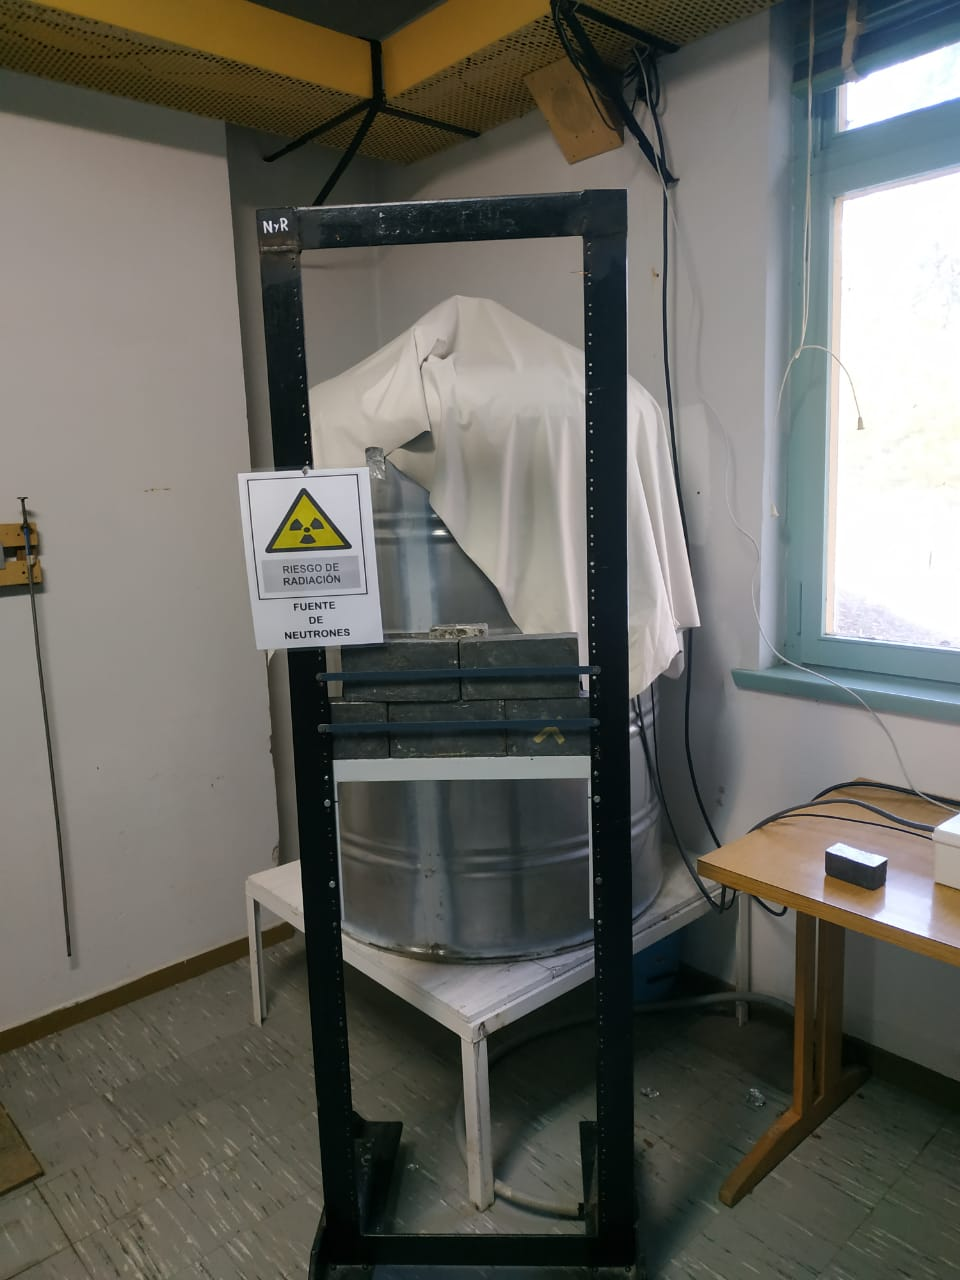

In [9]:
from IPython.display import Image

image_path = 'imgs/desnuda.jpg'

display(Image(filename=image_path, width=300, height=300))

In [10]:
all_max_per_file_AmBe_desnuda, all_sum_per_file_AmBe_desnuda = load_data(file_list_AmBe_desnuda)

Longitud de AmBe/ambe_desnuda_30cm_880t1_nogps_1970_01_01_00h00.dat: 99038176
Longitud de AmBe/fondo_ambe_desnuda_30cm_880t1_nogps_1970_01_01_00h00.dat: 4382656


Veamos todo el rango energético

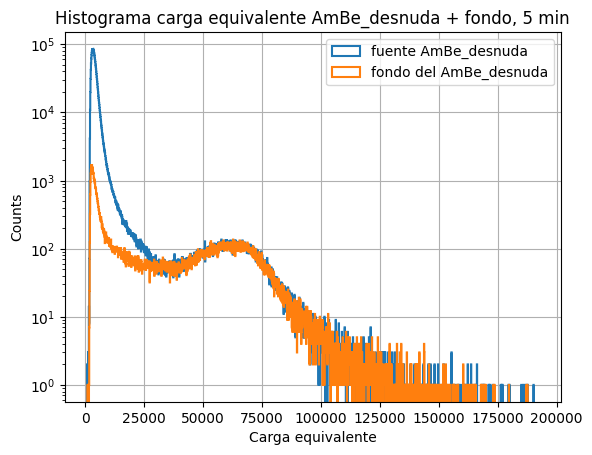

In [11]:
plot_histogram(
    all_sum_per_file_AmBe_desnuda, 
    bin_width=100, 
    labels=['fuente AmBe_desnuda', 'fondo del AmBe_desnuda'], 
    title='Histograma carga equivalente AmBe_desnuda + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

Hagamos zoom donde actúa la fuente

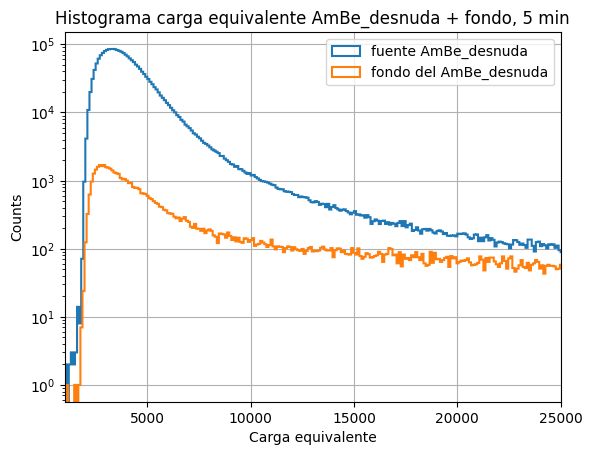

In [12]:
plot_histogram(
    all_sum_per_file_AmBe_desnuda, 
    bin_width=100, 
    labels=['fuente AmBe_desnuda', 'fondo del AmBe_desnuda'], 
    title='Histograma carga equivalente AmBe_desnuda + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True,
    xlim=(1000, 25000)
)

Guardamos un pedazo del espectro, de 4000 - 6000 parece bien

In [13]:
charge_thresholds_AmBe = (4000, 6000)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_AmBe_desnuda, charge_thresholds_AmBe, "AmBe_desnuda_filtered")

Datos guardados en AmBe_desnuda_filtered


In [14]:
AmBe_desnuda_filtered = np.loadtxt( 'AmBe_desnuda_filtered/fuente_pulsos.csv', delimiter=',')

Y el pulso medio

In [15]:
mean_pulse_AmBe_desnuda_filtered = np.mean(AmBe_desnuda_filtered, axis=0)

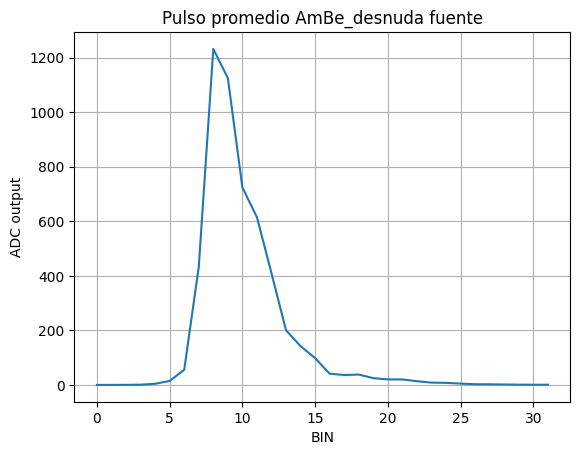

In [16]:
plt.plot(mean_pulse_AmBe_desnuda_filtered)
plt.title('Pulso promedio AmBe_desnuda fuente')
plt.xlabel('BIN')
plt.ylabel('ADC output')
plt.grid(True)
plt.show()

In [17]:
del all_max_per_file_AmBe_desnuda
del all_sum_per_file_AmBe_desnuda

### Fuente AmBe con blindaje Plomo

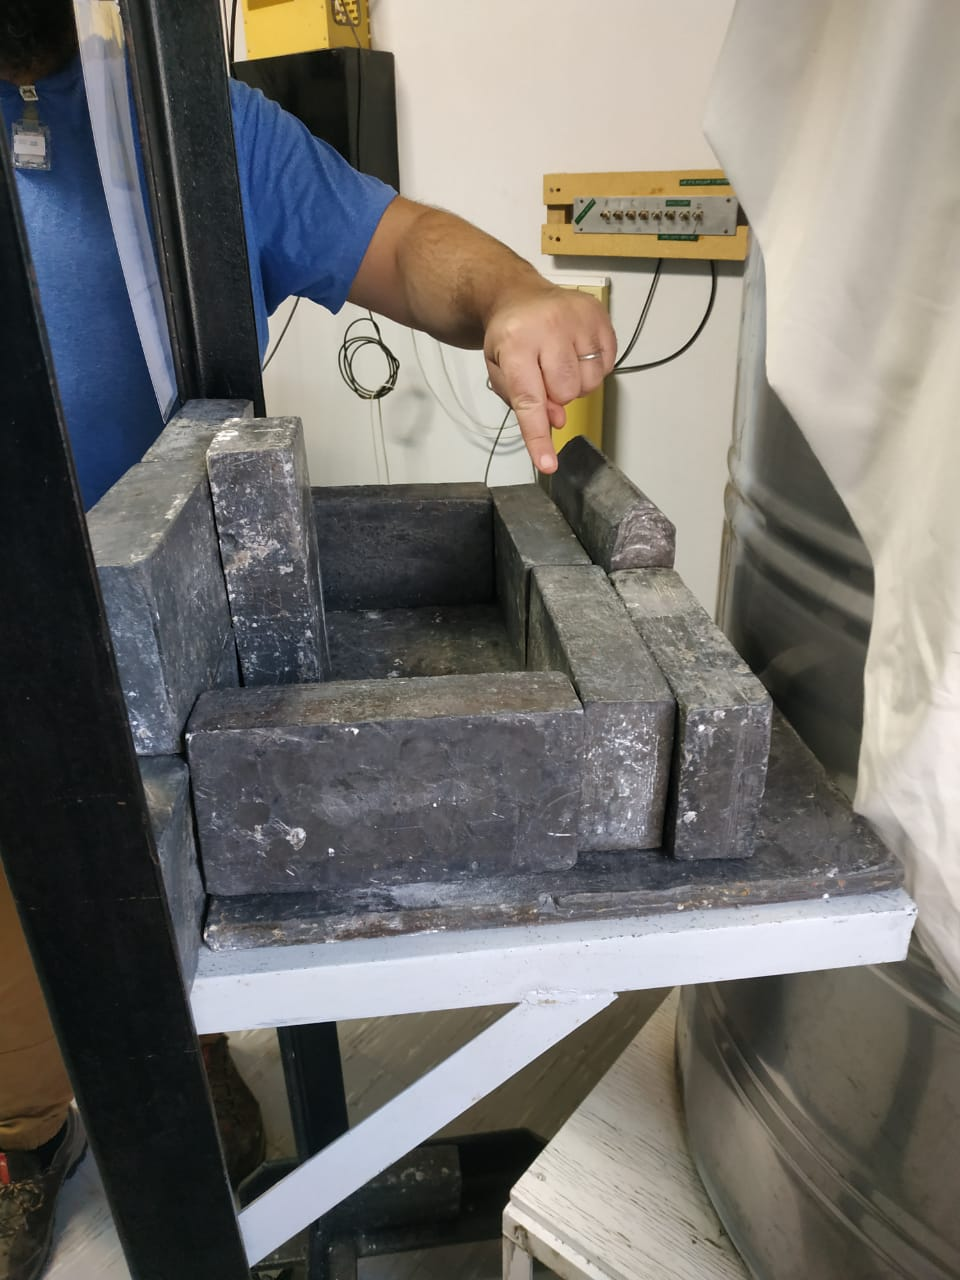

In [18]:
from IPython.display import Image

image_path = 'imgs/plomo.jpg'

display(Image(filename=image_path, width=300, height=300))

In [19]:
all_max_per_file_AmBe_plomo, all_sum_per_file_AmBe_plomo = load_data(file_list_AmBe_plomo)

Longitud de AmBe/ambe_plomo_30cm_880t1_nogps_1970_01_01_01h00.dat: 24154392
Longitud de AmBe/fondo_ambe_plomo_30cm_nogps_1970_01_01_01h00.dat: 4434268


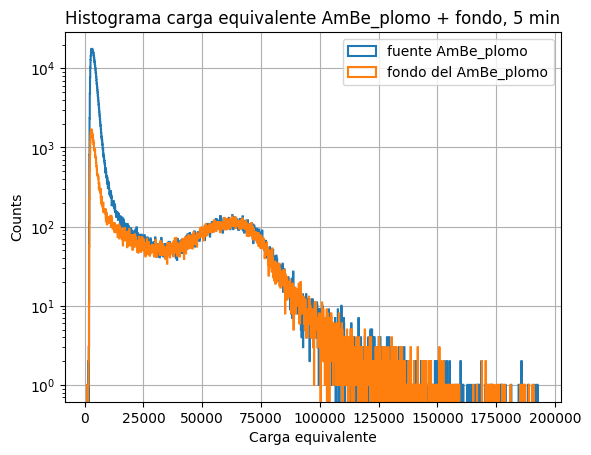

In [20]:
plot_histogram(
    all_sum_per_file_AmBe_plomo, 
    bin_width=100, 
    labels=['fuente AmBe_plomo', 'fondo del AmBe_plomo'], 
    title='Histograma carga equivalente AmBe_plomo + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

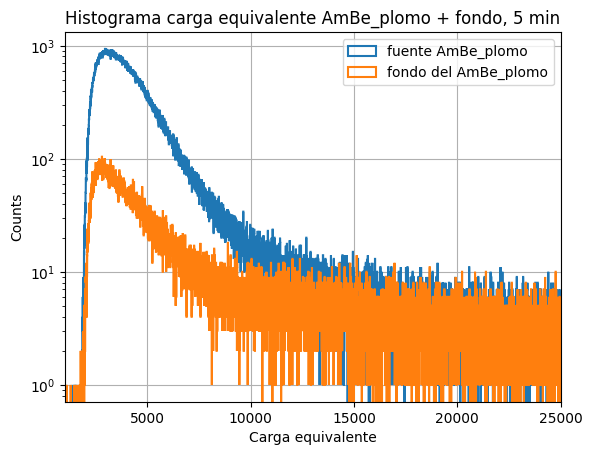

In [21]:
plot_histogram(
    all_sum_per_file_AmBe_plomo, 
    bin_width=5, 
    labels=['fuente AmBe_plomo', 'fondo del AmBe_plomo'], 
    title='Histograma carga equivalente AmBe_plomo + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True, 
    xlim=(1000, 25000)
)

In [22]:
charge_thresholds_AmBe = (4000, 6000)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_AmBe_plomo, charge_thresholds_AmBe, "AmBe_plomo_filtered")

Datos guardados en AmBe_plomo_filtered


In [23]:
AmBe_plomo_filtered = np.loadtxt( 'AmBe_plomo_filtered/fuente_pulsos.csv', delimiter=',')

In [24]:
mean_pulse_AmBe_plomo_filtered = np.mean(AmBe_plomo_filtered, axis=0)

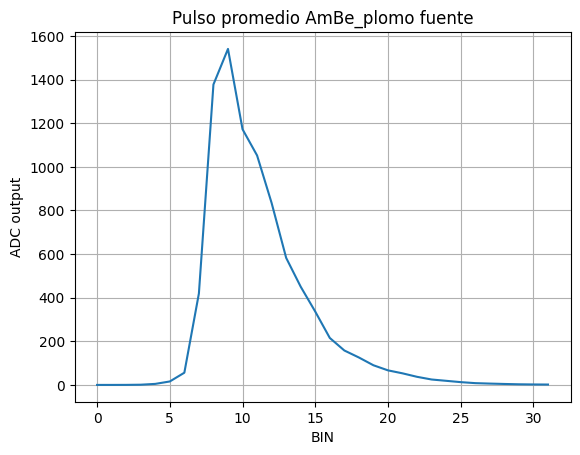

In [25]:
plt.plot(mean_pulse_AmBe_plomo_filtered)
plt.title('Pulso promedio AmBe_plomo fuente')
plt.xlabel('BIN')
plt.ylabel('ADC output')
plt.grid(True)
plt.show()

In [26]:
del all_max_per_file_AmBe_plomo
del all_sum_per_file_AmBe_plomo

### Fuente AmBe con blidaje Cadmio Parafina Borada

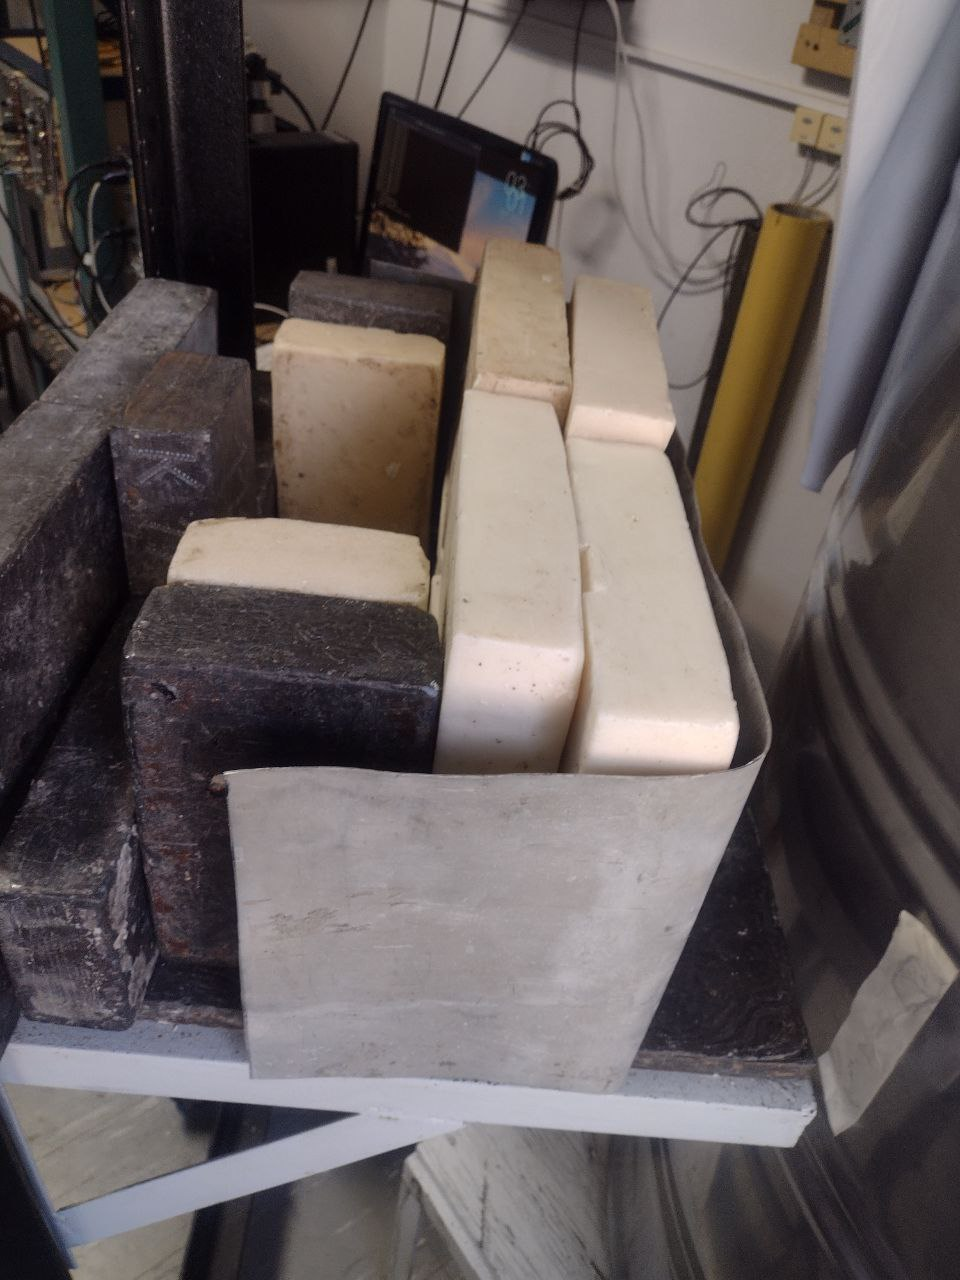

In [27]:
from IPython.display import Image

image_path = 'imgs/cdpb.jpg'

display(Image(filename=image_path, width=300, height=300))

In [28]:
all_max_per_file_AmBe_cdparafinab, all_sum_per_file_AmBe_cdparafinab = load_data(file_list_AmBe_cdparafinab)

Longitud de AmBe/ambe_cadmioparafinaborada_30cm_880t1_nogps_1970_01_01_02h00.dat: 66370304
Longitud de AmBe/fondo_ambe_cadmioparafinaborada_30cm_880t1_nogps_1970_01_01_02h00.dat: 4368412


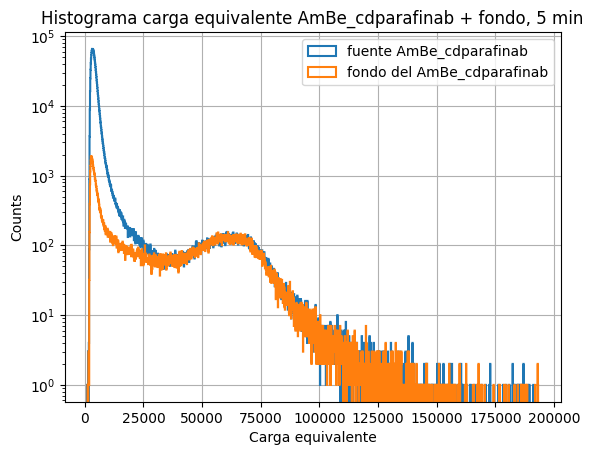

In [29]:
plot_histogram(
    all_sum_per_file_AmBe_cdparafinab, 
    bin_width=100, 
    labels=['fuente AmBe_cdparafinab', 'fondo del AmBe_cdparafinab'], 
    title='Histograma carga equivalente AmBe_cdparafinab + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

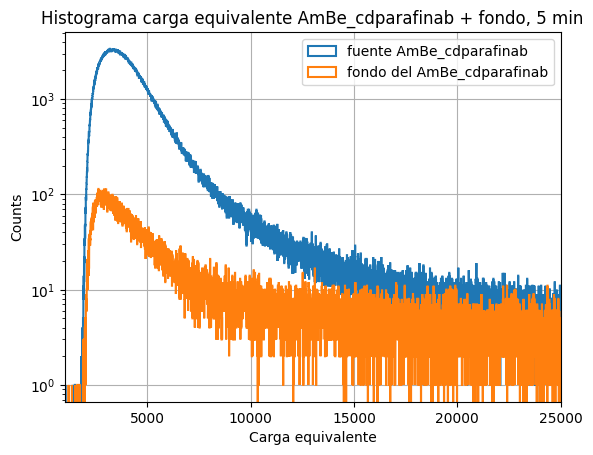

In [30]:
plot_histogram(
    all_sum_per_file_AmBe_cdparafinab, 
    bin_width=5, 
    labels=['fuente AmBe_cdparafinab', 'fondo del AmBe_cdparafinab'], 
    title='Histograma carga equivalente AmBe_cdparafinab + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True, 
    xlim=(1000, 25000)
)

In [31]:
charge_thresholds_AmBe = (4000, 6000)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_AmBe_cdparafinab, charge_thresholds_AmBe, "AmBe_cdparafinab_filtered")

Datos guardados en AmBe_cdparafinab_filtered


In [32]:
AmBe_cdparafinab_filtered = np.loadtxt( 'AmBe_cdparafinab_filtered/fuente_pulsos.csv', delimiter=',')

In [33]:
mean_pulse_AmBe_cdparafinab_filtered = np.mean(AmBe_cdparafinab_filtered, axis=0)

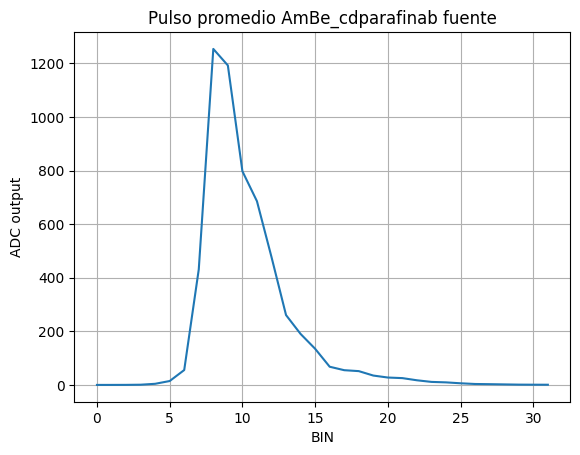

In [34]:
plt.plot(mean_pulse_AmBe_cdparafinab_filtered)
plt.title('Pulso promedio AmBe_cdparafinab fuente')
plt.xlabel('BIN')
plt.ylabel('ADC output')
plt.grid(True)
plt.show()

In [35]:
del all_max_per_file_AmBe_cdparafinab
del all_sum_per_file_AmBe_cdparafinab

### Fuente AmBe con blindaje Parafina Pura Plomo

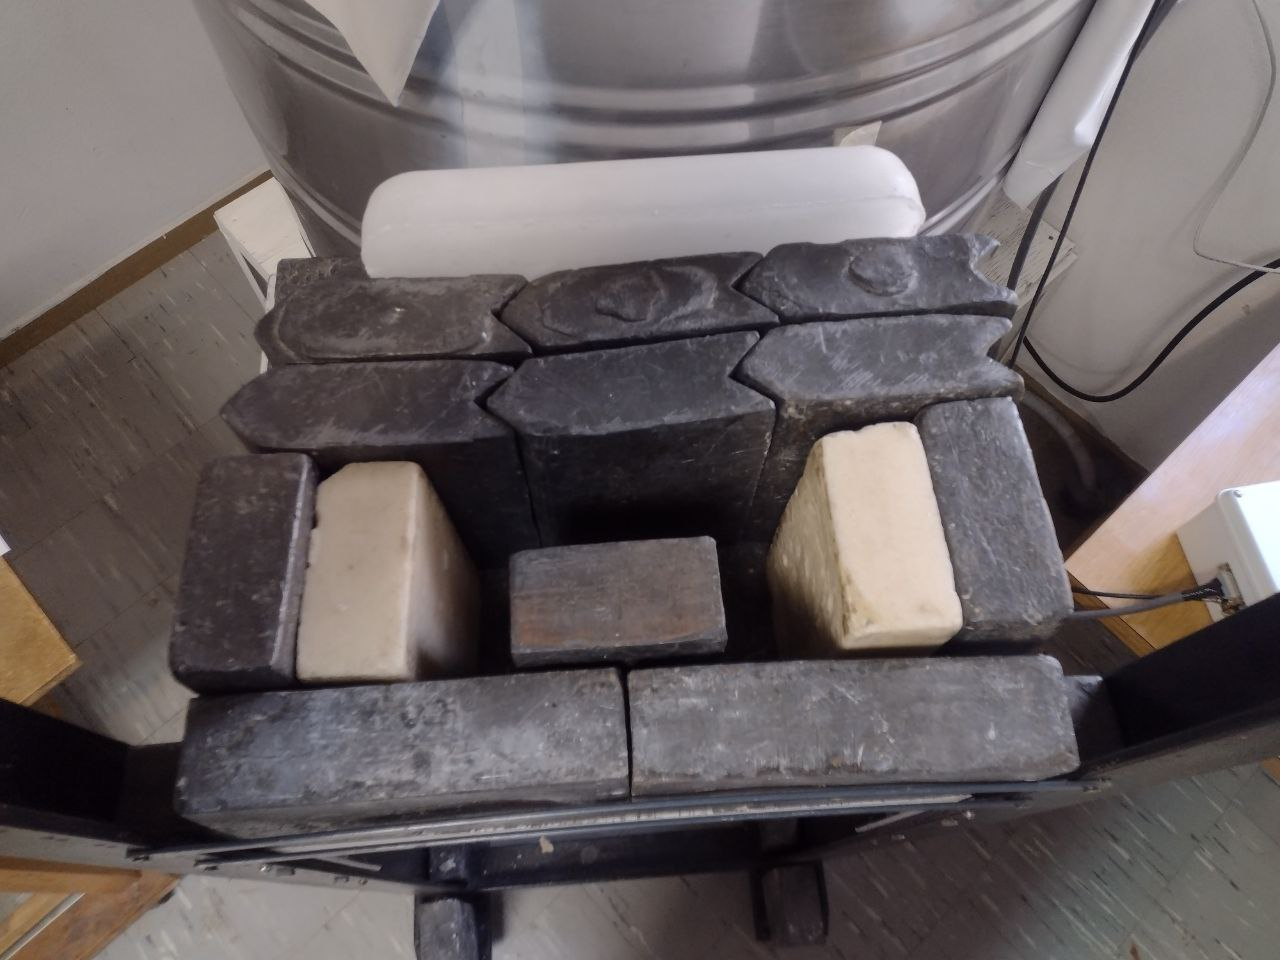

In [36]:
from IPython.display import Image

image_path = 'imgs/ppura.jpg'

display(Image(filename=image_path, width=300, height=300))

In [37]:
all_max_per_file_AmBe_pp2bloques, all_sum_per_file_AmBe_pp2bloques = load_data(file_list_AmBe_parafinapuraplomo2bloques)

Longitud de AmBe/ambe_parafinapuraplomo2bloques_30cm_880t1_nogps_1970_01_01_01h00.dat: 21922452
Longitud de AmBe/fondo_ambe_parafinapuraplomo2bloques_30cm_880t1_nogps_1970_01_01_01h00.dat: 4397600


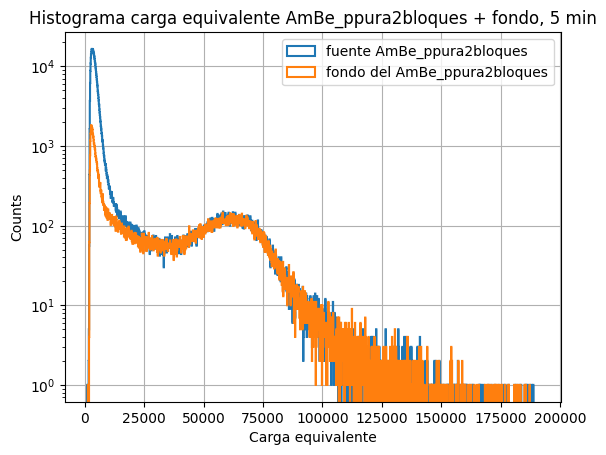

In [38]:
plot_histogram(
    all_sum_per_file_AmBe_pp2bloques, 
    bin_width=100, 
    labels=['fuente AmBe_ppura2bloques', 'fondo del AmBe_ppura2bloques'], 
    title='Histograma carga equivalente AmBe_ppura2bloques + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

In [39]:
charge_thresholds_AmBe = (4000, 6000)
save_filtered_data(file_list_AmBe_parafinapuraplomo2bloques, charge_thresholds_AmBe, "AmBe_ppura2bloques_filtered")

Datos guardados en AmBe_ppura2bloques_filtered


In [40]:
AmBe_plomo_filtered = np.loadtxt( 'AmBe_plomo_filtered/fuente_pulsos.csv', delimiter=',')
AmBe_pp2bloques_filtered = np.loadtxt( 'AmBe_ppura2bloques_filtered/fuente_pulsos.csv', delimiter=',')

In [41]:
all_max_per_file_AmBe_plomo, all_sum_per_file_AmBe_plomo = load_data(file_list_AmBe_plomo)

Longitud de AmBe/ambe_plomo_30cm_880t1_nogps_1970_01_01_01h00.dat: 24154392
Longitud de AmBe/fondo_ambe_plomo_30cm_nogps_1970_01_01_01h00.dat: 4434268


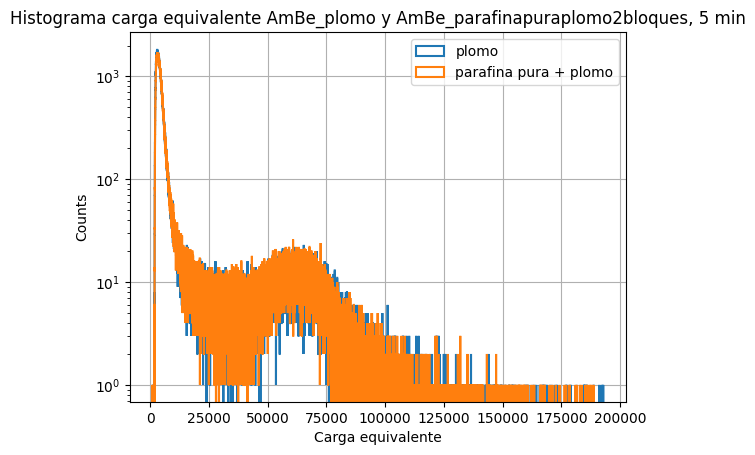

In [42]:
plt.hist(all_sum_per_file_AmBe_plomo[0], bins=np.arange(np.min(all_sum_per_file_AmBe_plomo[0]), np.max(all_sum_per_file_AmBe_plomo[0]), 10), histtype='step', label='plomo',linewidth=1.5)
plt.hist(all_sum_per_file_AmBe_pp2bloques[0], bins=np.arange(np.min(all_sum_per_file_AmBe_pp2bloques[0]), np.max(all_sum_per_file_AmBe_pp2bloques[0]), 10), histtype='step', label='parafina pura + plomo',linewidth=1.5)
plt.xlabel('Carga equivalente')
plt.ylabel('Counts')
plt.title('Histograma carga equivalente AmBe_plomo y AmBe_parafinapuraplomo2bloques, 5 min')
plt.legend()
plt.yscale('log')
# plt.xlim(4000,)
plt.grid(True)
plt.show()

In [43]:
mean_pulse_AmBe_plomo_filtered = np.mean(AmBe_plomo_filtered, axis=0)
mean_pulse_AmBe_pp2bloques_filtered = np.mean(AmBe_pp2bloques_filtered, axis=0)

### Veamos una comparación entre los 4 tipos de pulsos

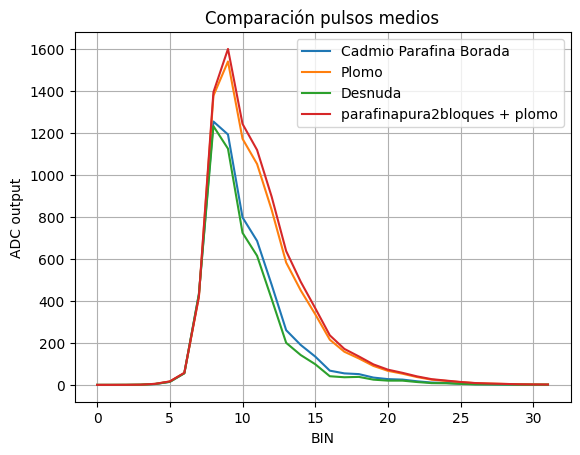

In [44]:
plt.plot(mean_pulse_AmBe_cdparafinab_filtered, label = 'Cadmio Parafina Borada')
plt.plot(mean_pulse_AmBe_plomo_filtered, label = 'Plomo')
plt.plot(mean_pulse_AmBe_desnuda_filtered, label = 'Desnuda')
plt.plot(mean_pulse_AmBe_pp2bloques_filtered, label = 'parafinapura2bloques + plomo')
plt.title('Comparación pulsos medios')
plt.xlabel('BIN')
plt.legend()
plt.grid()
plt.ylabel('ADC output')
plt.show()

In [45]:
del all_sum_per_file_AmBe_pp2bloques
del all_max_per_file_AmBe_pp2bloques
del all_sum_per_file_AmBe_plomo
del all_max_per_file_AmBe_plomo

### Clasificador basado en stacking

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def cargar_datos(neutrones_file, gamma_file):
    """
    Carga los datos de neutrones y gamma desde los archivos proporcionados y crea las etiquetas correspondientes.

    Args:
        neutrones_file (str): Ruta del archivo que contiene los datos de neutrones.
        gamma_file (str): Ruta del archivo que contiene los datos de gamma y neutrones.

    Returns:
        tuple: Una tupla que contiene los datos combinados y las etiquetas correspondientes.
            - data (ndarray): Un array numpy que contiene los datos combinados de neutrones y gamma.
            - labels (ndarray): Un array numpy que contiene las etiquetas correspondientes a los datos.
                1 representa neutrones y 0 representa gamma.
    """
    neutrones_pulsos = np.loadtxt(neutrones_file, delimiter=',')
    gamma_pulsos = np.loadtxt(gamma_file, delimiter=',')
    
    # Etiquetas: 1 para neutrones y 0 para gamma 
    labels = np.array([1] * neutrones_pulsos.shape[0] + [0] * gamma_pulsos.shape[0])
    data = np.vstack((neutrones_pulsos, gamma_pulsos))
    return data, labels

neutrones_file = 'AmBe_plomo_filtered/fuente_pulsos.csv'
gamma_file = 'AmBe_cdparafinab_filtered/fuente_pulsos.csv'

data, labels = cargar_datos(neutrones_file, gamma_file)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [11]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier


estimators = [
    ('gb', GradientBoostingClassifier(n_estimators=200, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stacking_clf.fit(X_train, y_train)

In [ ]:
y_pred_stack = stacking_clf.predict(X_test)

print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stack))
print("Classification Report:\n", classification_report(y_test, y_pred_stack))

Stacking Classifier Accuracy: 0.8303774410821955
Confusion Matrix:
 [[103172   8085]
 [ 15940  14441]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90    111257
           1       0.64      0.48      0.55     30381

    accuracy                           0.83    141638
   macro avg       0.75      0.70      0.72    141638
weighted avg       0.82      0.83      0.82    141638



La precisión para la clase 1 es aceptable, pero el recall es bastante bajo. Esto significa que el modelo tiene dificultades para identificar correctamente todos los ejemplos de la clase 1.
Aunque la exactitud general del modelo es alta, el bajo recall para la clase 1 sugiere que el modelo podría estar sesgado hacia la clase 0, lo que es un problema común en conjuntos de datos desbalanceados.

In [ ]:
import joblib
import os

file_name = 'stacking_clf_gb_rf.pkl'

directory = 'models'

if not os.path.exists(directory):
    os.makedirs(directory)

# Ruta completa del archivo
filepath = os.path.join(directory, file_name)

# Guardar el modelo utilizando joblib
joblib.dump(stacking_clf, filepath)

print(f"Modelo guardado exitosamente en '{filepath}'.")

In [5]:
import joblib
import os

file_name = 'stacking_clf_gb_rf.pkl'
directory = 'models'

filepath = os.path.join(directory, file_name)

stacking_clf = joblib.load(filepath)

print(f"Modelo cargado exitosamente desde '{filepath}'.")

Modelo cargado exitosamente desde 'models/stacking_clf_gb_rf.pkl'.


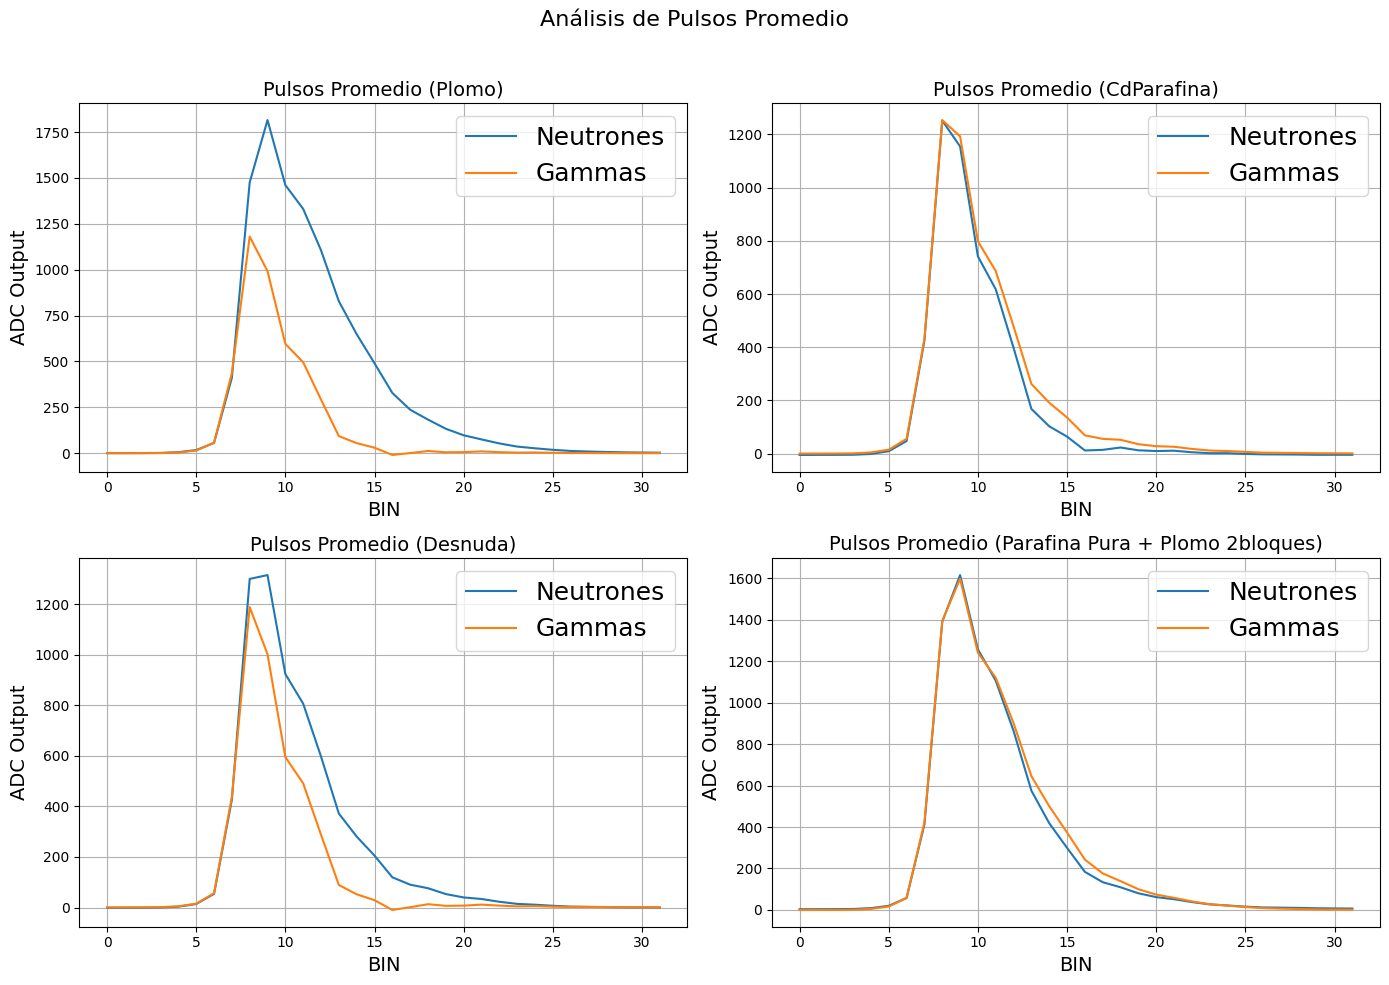

Cantidad de neutrones en plomo: 101369
Cantidad de gammas en plomo: 50844


Cantidad de neutrones en ppura2bloques: 17073
Cantidad de gammas en ppura2bloques: 137337


Cantidad de neutrones en cdparafinab: 5535
Cantidad de gammas en cdparafinab: 550438


Cantidad de neutrones en desnuda: 277947
Cantidad de gammas en desnuda: 428569


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def load_and_predict(file, model, scaler):
    data = np.loadtxt(file, delimiter=',')
    y_pred_all = model.predict(data)
    y_pred_all_classes = y_pred_all  
    neutron_pulses = data[y_pred_all_classes == 1]
    gamma_pulses = data[y_pred_all_classes == 0]
    return neutron_pulses, gamma_pulses

def plot_pulse_average(ax, pulse_data, title, label):
    ax.plot(np.mean(pulse_data, axis=0), label=label)
    ax.set_title(title, fontsize = 14)
    ax.set_xlabel('BIN', fontsize = 14)
    ax.set_ylabel('ADC Output', fontsize = 14)
    ax.grid(True)
    ax.legend(fontsize = 18)

scaler = StandardScaler()
best_model = stacking_clf  # Usar el mejor modelo obtenido

desnuda_file = 'AmBe_desnuda_filtered/fuente_pulsos.csv'
ppura2bloques_file = 'AmBe_ppura2bloques_filtered/fuente_pulsos.csv'
cdparafinab_file = 'AmBe_cdparafinab_filtered/fuente_pulsos.csv'
plomo_file = 'AmBe_plomo_filtered/fuente_pulsos.csv'

neutron_pulses_desnuda, gamma_pulses_desnuda = load_and_predict(desnuda_file, best_model, scaler)

neutron_pulses_plomo, gamma_pulses_plomo = load_and_predict(plomo_file, best_model, scaler)

neutron_pulses_cdb, gamma_pulses_cdb = load_and_predict(cdparafinab_file, best_model, scaler)

neutron_pulses_ppura2bloques, gamma_pulses_ppura2bloques = load_and_predict(ppura2bloques_file, best_model, scaler)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Subplots
plot_pulse_average(axes[0, 0], neutron_pulses_plomo, 'Pulsos Promedio (Plomo)', 'Neutrones')
plot_pulse_average(axes[0, 0], gamma_pulses_plomo, 'Pulsos Promedio (Plomo)', 'Gammas')

plot_pulse_average(axes[0, 1], neutron_pulses_cdb, 'Pulsos Promedio (CdParafina)', 'Neutrones')
plot_pulse_average(axes[0, 1], gamma_pulses_cdb, 'Pulsos Promedio (CdParafina)', 'Gammas')

plot_pulse_average(axes[1, 0], neutron_pulses_desnuda, 'Pulsos Promedio (Desnuda)', 'Neutrones')
plot_pulse_average(axes[1, 0], gamma_pulses_desnuda, 'Pulsos Promedio (Desnuda)', 'Gammas')

plot_pulse_average(axes[1, 1], neutron_pulses_ppura2bloques, 'Pulsos Promedio (Parafina Pura + Plomo 2bloques)', 'Neutrones')
plot_pulse_average(axes[1, 1], gamma_pulses_ppura2bloques, 'Pulsos Promedio (Parafina Pura + Plomo 2bloques)', 'Gammas')


fig.suptitle('Análisis de Pulsos Promedio', fontsize=16)

# Ajustar el layout para que los subplots no se superpongan
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Mostrar la gráfica
plt.show()

print(f'Cantidad de neutrones en plomo: {neutron_pulses_plomo.shape[0]}')
print(f'Cantidad de gammas en plomo: {gamma_pulses_plomo.shape[0]}')
print('\n')
print(f'Cantidad de neutrones en ppura2bloques: {neutron_pulses_ppura2bloques.shape[0]}')
print(f'Cantidad de gammas en ppura2bloques: {gamma_pulses_ppura2bloques.shape[0]}')
print('\n')
print(f'Cantidad de neutrones en cdparafinab: {neutron_pulses_cdb.shape[0]}')
print(f'Cantidad de gammas en cdparafinab: {gamma_pulses_cdb.shape[0]}')
print('\n')
print(f'Cantidad de neutrones en desnuda: {neutron_pulses_desnuda.shape[0]}')
print(f'Cantidad de gammas en desnuda: {gamma_pulses_desnuda.shape[0]}')

In [ ]:
del stacking_clf

### Clasificador basado en voting

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Importar clasificadores
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Cargar los datos
neutrones_file = 'AmBe_plomo_filtered/fuente_pulsos.csv'
gamma_file = 'AmBe_cdparafinab_filtered/fuente_pulsos.csv'

def cargar_datos(neutrones_file, gamma_file):
    neutrones_pulsos = np.loadtxt(neutrones_file, delimiter=',')
    gamma_pulsos = np.loadtxt(gamma_file, delimiter=',')
    labels = np.array([1] * neutrones_pulsos.shape[0] + [0] * gamma_pulsos.shape[0])
    data = np.vstack((neutrones_pulsos, gamma_pulsos))
    return data, labels

data, labels = cargar_datos(neutrones_file, gamma_file)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Ajustar manualmente los pesos de las clases en algunos clasificadores
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

voting_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: class_weights[0], 1: class_weights[1]})),
    ('dt', DecisionTreeClassifier(random_state=42, class_weight={0: class_weights[0], 1: class_weights[1]})),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=class_weights[1]/class_weights[0]))
]

# Crear el VotingClassifier
voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')

# Entrenar el modelo
voting_clf.fit(X_train, y_train)

param_grid = {
    'rf__n_estimators': [100], 
    'xgb__n_estimators': [100],
    'xgb__max_depth': [5]
}

grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
# Evaluar el modelo optimizado en el conjunto de prueba
best_voting_clf = grid_search.best_estimator_
y_pred = best_voting_clf.predict(X_test)

# Resultados
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Parameters: {'rf__n_estimators': 100, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}
Accuracy: 0.7978155579717308
[[99973 11284]
 [17353 13028]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87    111257
           1       0.54      0.43      0.48     30381

    accuracy                           0.80    141638
   macro avg       0.69      0.66      0.68    141638
weighted avg       0.78      0.80      0.79    141638



La exactitud del modelo es relativamente alta (79.78%), pero la precisión y el recall para la clase 1 (la minoritaria) son más bajos en comparación con la clase 0. La precisión para la clase 1 es 0.54 y el recall es 0.43, lo que indica que el modelo tiene dificultades para identificar correctamente los casos de la clase 1. El F1-score para la clase 1 es bajo (0.48), reflejando la dificultad en equilibrar la precisión y el recall para esa clase.

Este modelo tiene un rendimiento razonable en términos de exactitud general, pero su capacidad para detectar la clase minoritaria (clase 1) puede mejorarse.

In [ ]:
import joblib
import os

file_name = 'voting_clf_dt_rf_xgb.pkl'

directory = 'models'

if not os.path.exists(directory):
    os.makedirs(directory)

# Ruta completa del archivo
filepath = os.path.join(directory, file_name)

# Guardar el modelo utilizando joblib
joblib.dump(voting_clf, filepath)

print(f"Modelo guardado exitosamente en '{filepath}'.")

Modelo guardado exitosamente en 'models/voting_clf_dt_rf_xgb.pkl'.


In [7]:
import joblib
import os

file_name = 'voting_clf_dt_rf_xgb.pkl'
directory = 'models'

filepath = os.path.join(directory, file_name)

voting_clf = joblib.load(filepath)

print(f"Modelo cargado exitosamente desde '{filepath}'.")

Modelo cargado exitosamente desde 'models/voting_clf_dt_rf_xgb.pkl'.


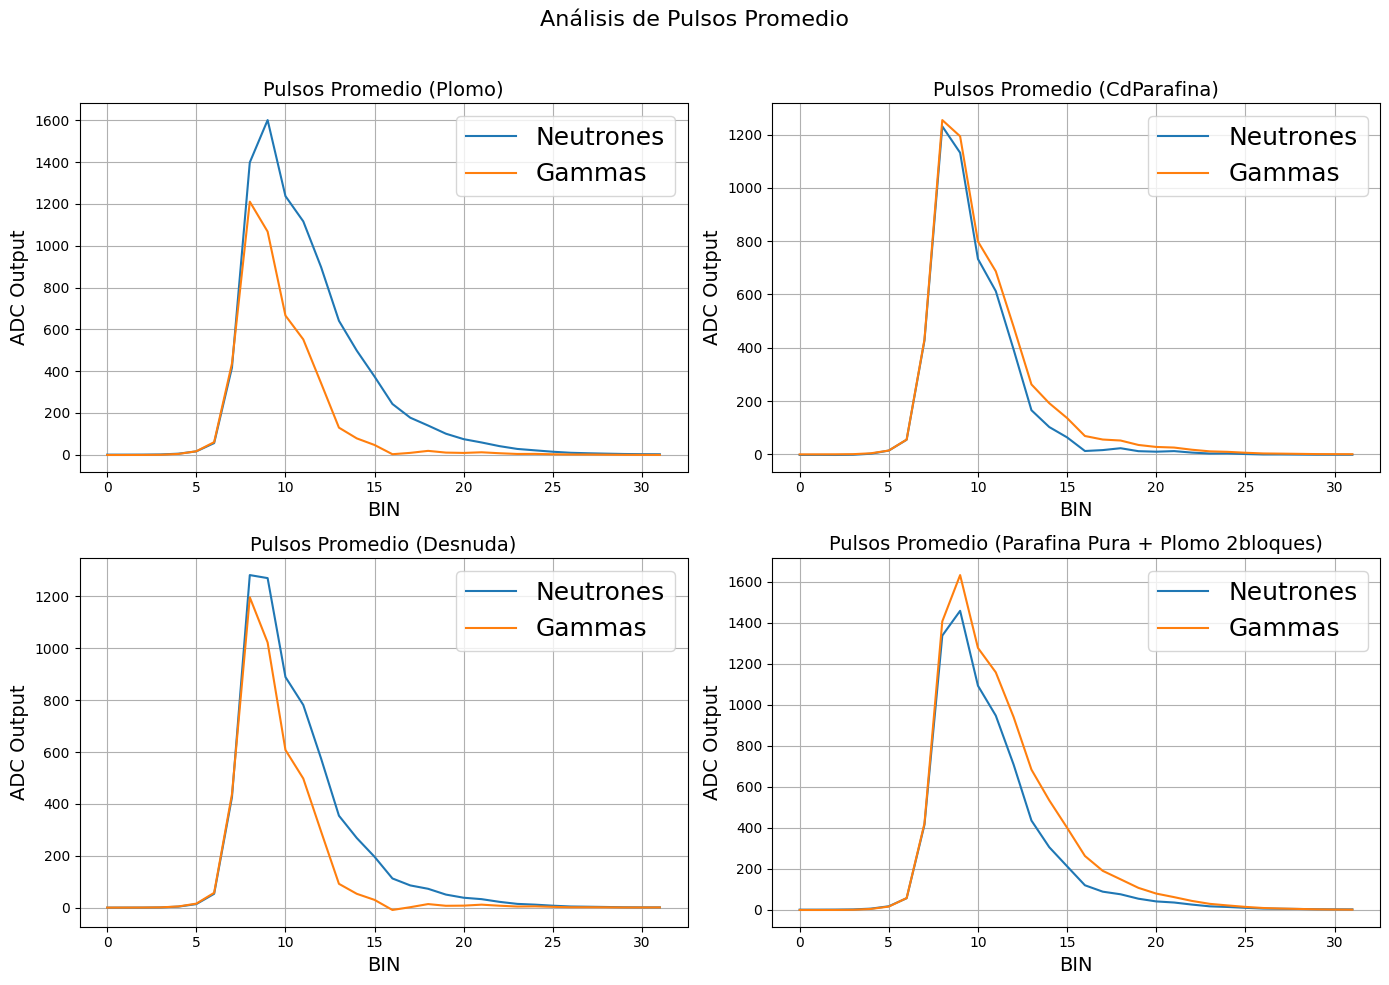

Cantidad de neutrones en plomo: 134847
Cantidad de gammas en plomo: 17366


Cantidad de neutrones en ppura2bloques: 29103
Cantidad de gammas en ppura2bloques: 125307


Cantidad de neutrones en cdparafinab: 11083
Cantidad de gammas en cdparafinab: 544890


Cantidad de neutrones en desnuda: 291842
Cantidad de gammas en desnuda: 414674


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def load_and_predict(file, model, scaler):
    data = np.loadtxt(file, delimiter=',')
    # data_scaled = scaler.transform(data)  # Usar transform en lugar de fit_transform
    y_pred_all = model.predict(data)
    y_pred_all_classes = y_pred_all  # Asumiendo que el modelo devuelve las clases
    # data_descaled = scaler.inverse_transform(data_scaled)
    neutron_pulses = data[y_pred_all_classes == 1]
    gamma_pulses = data[y_pred_all_classes == 0]
    return neutron_pulses, gamma_pulses

def plot_pulse_average(ax, pulse_data, title, label):
    ax.plot(np.mean(pulse_data, axis=0), label=label)
    ax.set_title(title, fontsize = 14)
    ax.set_xlabel('BIN', fontsize = 14)
    ax.set_ylabel('ADC Output', fontsize = 14)
    ax.grid(True)
    ax.legend(fontsize = 18)

scaler = StandardScaler()
best_model = voting_clf  # Usar el mejor modelo obtenido


desnuda_file = 'AmBe_desnuda_filtered/fuente_pulsos.csv'
ppura2bloques_file = 'AmBe_ppura2bloques_filtered/fuente_pulsos.csv'
cdparafinab_file = 'AmBe_cdparafinab_filtered/fuente_pulsos.csv'
plomo_file = 'AmBe_plomo_filtered/fuente_pulsos.csv'

neutron_pulses_desnuda, gamma_pulses_desnuda = load_and_predict(desnuda_file, best_model, scaler)

neutron_pulses_plomo, gamma_pulses_plomo = load_and_predict(plomo_file, best_model, scaler)

neutron_pulses_cdb, gamma_pulses_cdb = load_and_predict(cdparafinab_file, best_model, scaler)

neutron_pulses_ppura2bloques, gamma_pulses_ppura2bloques = load_and_predict(ppura2bloques_file, best_model, scaler)


# Crear subplots con 2 filas y 2 columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Subplots
plot_pulse_average(axes[0, 0], neutron_pulses_plomo, 'Pulsos Promedio (Plomo)', 'Neutrones')
plot_pulse_average(axes[0, 0], gamma_pulses_plomo, 'Pulsos Promedio (Plomo)', 'Gammas')

plot_pulse_average(axes[0, 1], neutron_pulses_cdb, 'Pulsos Promedio (CdParafina)', 'Neutrones')
plot_pulse_average(axes[0, 1], gamma_pulses_cdb, 'Pulsos Promedio (CdParafina)', 'Gammas')

plot_pulse_average(axes[1, 0], neutron_pulses_desnuda, 'Pulsos Promedio (Desnuda)', 'Neutrones')
plot_pulse_average(axes[1, 0], gamma_pulses_desnuda, 'Pulsos Promedio (Desnuda)', 'Gammas')

plot_pulse_average(axes[1, 1], neutron_pulses_ppura2bloques, 'Pulsos Promedio (Parafina Pura + Plomo 2bloques)', 'Neutrones')
plot_pulse_average(axes[1, 1], gamma_pulses_ppura2bloques, 'Pulsos Promedio (Parafina Pura + Plomo 2bloques)', 'Gammas')


fig.suptitle('Análisis de Pulsos Promedio', fontsize=16)

# Ajustar el layout para que los subplots no se superpongan
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Mostrar la gráfica
plt.show()

print(f'Cantidad de neutrones en plomo: {neutron_pulses_plomo.shape[0]}')
print(f'Cantidad de gammas en plomo: {gamma_pulses_plomo.shape[0]}')
print('\n')
print(f'Cantidad de neutrones en ppura2bloques: {neutron_pulses_ppura2bloques.shape[0]}')
print(f'Cantidad de gammas en ppura2bloques: {gamma_pulses_ppura2bloques.shape[0]}')
print('\n')
print(f'Cantidad de neutrones en cdparafinab: {neutron_pulses_cdb.shape[0]}')
print(f'Cantidad de gammas en cdparafinab: {gamma_pulses_cdb.shape[0]}')
print('\n')
print(f'Cantidad de neutrones en desnuda: {neutron_pulses_desnuda.shape[0]}')
print(f'Cantidad de gammas en desnuda: {gamma_pulses_desnuda.shape[0]}')

In [ ]:
del voting_clf